In [1]:
import os
import sys
import pdir

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


In [2]:
end='2017-05-15'
start='2007-01-01'
get_px=lambda x:web.DataReader(x,'yahoo',start=start,end=end)['Adj Close']

symbols=['SPY','TLT','MSFT']
data=pd.DataFrame({sym:get_px(sym) for sym in symbols})

#log returns
lrets=np.log(data/data.shift(1)).dropna()

RemoteDataError: Unable to read URL: http://ichart.finance.yahoo.com/table.csv?a=0&ignore=.csv&s=SPY&b=1&e=15&d=4&g=d&f=2017&c=2007

In [3]:
a=get_px(symbols[0])

RemoteDataError: Unable to read URL: http://ichart.finance.yahoo.com/table.csv?a=0&ignore=.csv&s=SPY&b=1&e=15&d=4&g=d&f=2017&c=2007

In [ ]:
data.head()

## stationarity  
* The mean of the series should not be a function of time
* The variance of the series should not be a function of time
* The covariance of the i th term and the (i+m) th term should not be a function of time.  


Most TS we encounter in finance is NOT stationary.Therefore a large part of TSA involves identifying if the series we want to predict is stationary,and if it is not we must find ways to transform it such that it is stationary.  

#### Series Correlation(Autocorrelation)  
Essentially when we model a time series we decompose teh series into three components:trend,seasonal/cyclical,and random.The random component is called the residual or error.It is simply the difference between our predicted values and the observed value(s).Series correlation is when the residuals of our TS models are correlated with each other.  

#### Why do we care about serial correlation?  
We care about serial correlation because it is critical for our model predictions,and is intrinsically related to stationary.Recall that the residuals (errors) of a sationary TS are serially uncorrelated by definition!if we fail to account for this in our models the standard errors of our coefficients are underestimated,inflating the size of our T-statistics.The result is too many Type-1 errors,where we reject our null hypothesis even when it is True! **In laymen's term,ignoring autocorrelation means our model predictions will be bunk,and we're likely to draw incorrect conclusions about the impact of the independent variables in our model.**  


In [4]:
def tsplot(y,lags=30,figsize=(10,8),style='bmh'):
    if not isinstance(y,pd.Series):
        y=pd.Series(y)
    
    with plt.style.context(style):
        fig=plt.figure(figsize=figsize)
        layout=(3,2)
        ts_ax=plt.subplot2grid(layout,(0,0),colspan=2)
        acf_ax=plt.subplot2grid(layout,(1,0))
        pacf_ax=plt.subplot2grid(layout,(1,1))
        qq_ax=plt.subplot2grid(layout,(2,0))
        pp_ax=plt.subplot2grid(layout,(2,1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y,lags=lags,ax=acf_ax,alpha=0.5)
        smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax,alpha=0.5)
        sm.qqplot(y,line='s',ax=qq_ax)
        qq_ax.set_title('QQ plot')
        scs.probplot(y,sparams=(y.mean(),y.std()),plot=pp_ax)
        
        plt.tight_layout()
    return

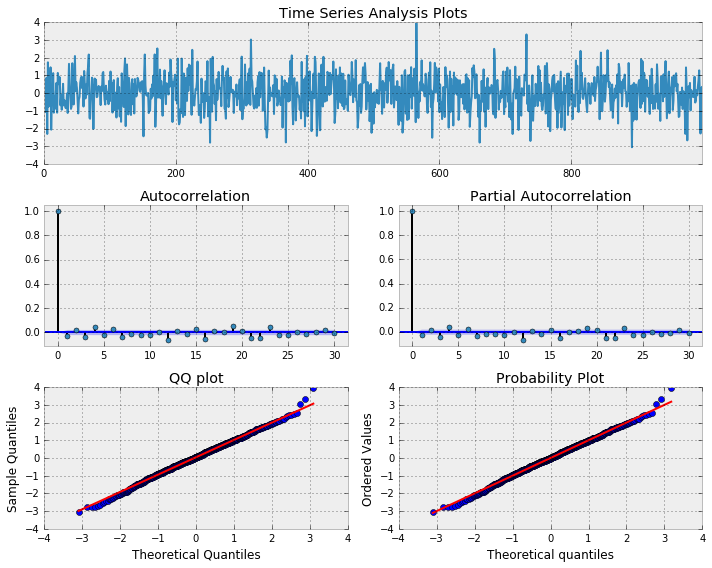

In [5]:
np.random.seed(1)

#plot of discrete white noise
randser=np.random.normal(size=1000)
tsplot(randser,lags=30)

In [6]:
print 'Random Series\n---------------------\nmean:{:.3f}\nvariance:{:.3f}\nstandard diviation:{:.3f}' \
.format(randser.mean(),randser.var(),randser.std())

Random Series
---------------------
mean:0.039
variance:0.962
standard diviation:0.981


** random walk:** $x_t=x_{t-1}+w_t$

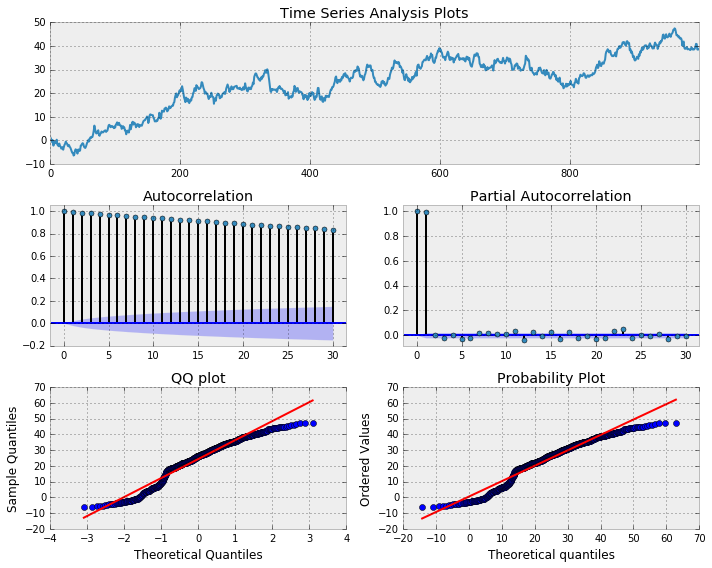

In [7]:
#Random walk without a drift

np.random.seed(1)
n_samples=1000

x=w=np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t]=x[t-1]+w[t]
_=tsplot(x,lags=30)

Clearly our TS is not stationary.Let's find out if the random walk model is a good fit for our simulated data.Recall that a random walk is $x_t=x_{t-1}+w_t$.Thus the first differences of our random walk series should equal a white noise process!We can use the ``np.diff()`` function on our TS and see if this holds.

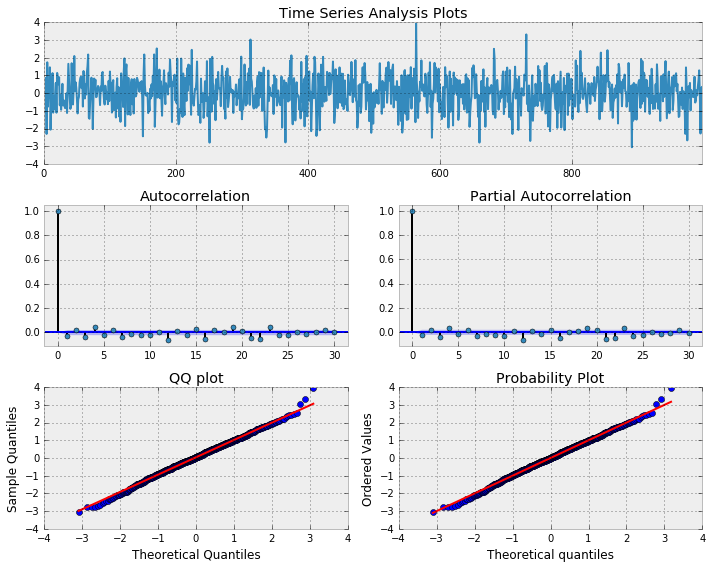

In [8]:
#First difference of simulated random walk series

_ =tsplot(np.diff(x),lags=30)

#### Linear Models  
$$y_t=b_0+b_1+\epsilon_t$$

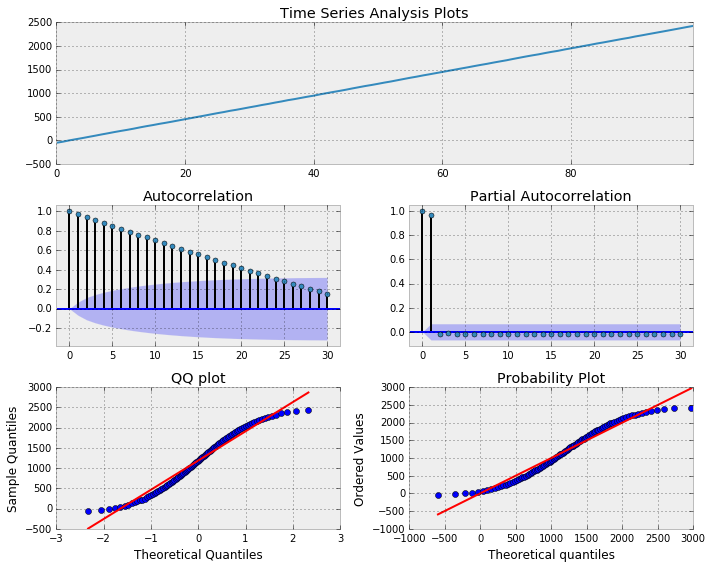

In [9]:
w=np.random.randn(100)
y=np.empty_like(w)
b0=-50
b1=25
for t in range(len(w)):
    y[t]=b0+b1*t+w[t]

_=tsplot(y,lags=30)

## Log-Linear Models  

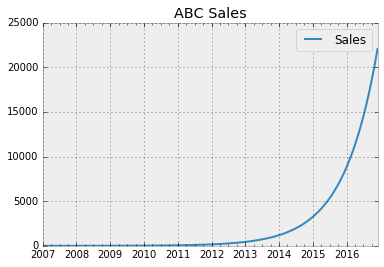

In [10]:
idx=pd.date_range('2007-01-01','2017-01-01',freq='M')
sales=[np.exp(x/12.0) for x in range(1,len(idx)+1)]
df=pd.DataFrame(sales,columns=['Sales'],index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

We can then transform the data by taking the natural logrithm of sales.Now a linear regression is a much better fit to the data.

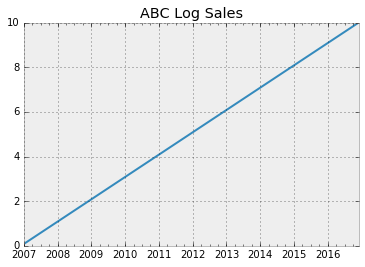

In [11]:
with plt.style.context('bmh'):
    pd.Series(np.log(sales),index=idx).plot()
    plt.title('ABC Log Sales')

## Autoregressive Models-AR(p)  
The formula looks like this:
$$
\begin {align}
x_t&=a_1x_{t-1}+\cdots+a_px_{t-p}+w_t\\
   &=\sum_{i=1}^{p}a_ix_{t-i}+w_t
\end {align}
$$

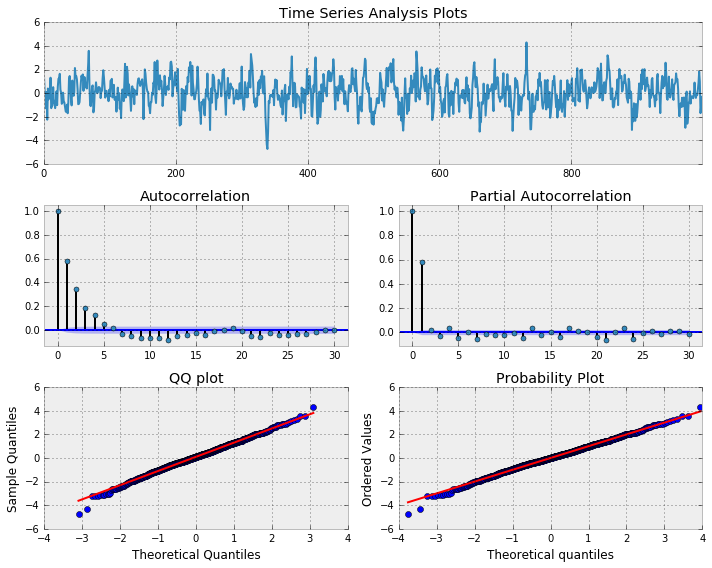

In [12]:
#simulate an AR(1) with alpha=0.6

np.random.seed(1)
n_samples=int(1000)
a=0.6
x=w=np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t]=x[t-1]*a+w[t]

_=tsplot(x,lags=30)

As expected the distribution of our simulated AR(1) model is normal.There is significant serial correlation between lagged values especially at lag 1 as evidenced by the PACF plot.  

Now we can fit an AR(p) model using Python's stats models.First we fit the AR model to our simulated data and return the estimated alpha coefficient.Then we use teh statsmodels function ``select_order()`` to see if the fitted model will select the correct lag.If the AR model is correct the estimated alpha coefficient will be close to our true alpha of 0.6 and the selected order will equal 1.

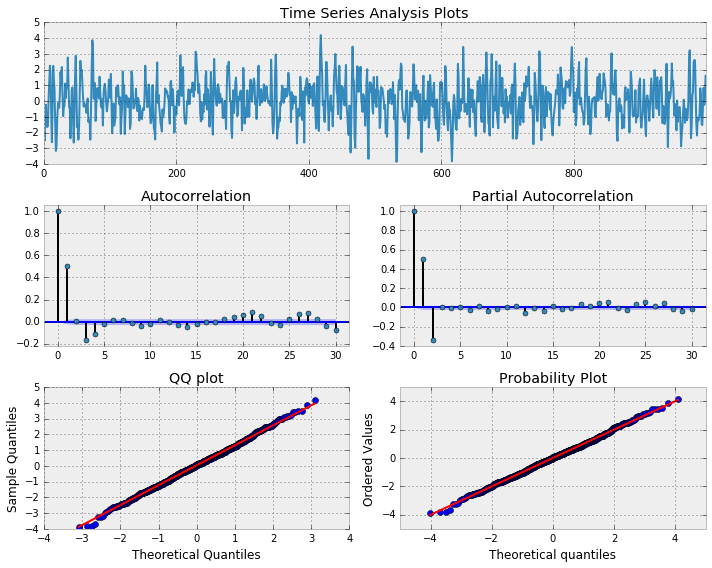

In [13]:
#Simulate AR(2) process

n=int(1000)
alphas=np.array([0.666,-0.333])
betas=np.array([0.])

#Python requires us to specify the zero-lag value which is 1
#Also note that the alphas for the AR model must be negated
#We also set the betas for the MA equal to 0 for an AR(p) model
#For more information see teh examples at statsmodels.org
ar=np.r_[1,-alphas]
ma=np.r_[1,betas]

ar2=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n)
_ =tsplot(ar2,lags=30)

## Moving Average models-MA(q)  
$$
\begin{align}
    x_t&=w_t+\beta w_{t-1}+\cdots+\beta_pw_{t-p}\\
       &=w_t+\sum_{i-1}^{p}\beta_iw_{i-1}
\end{align}
$$

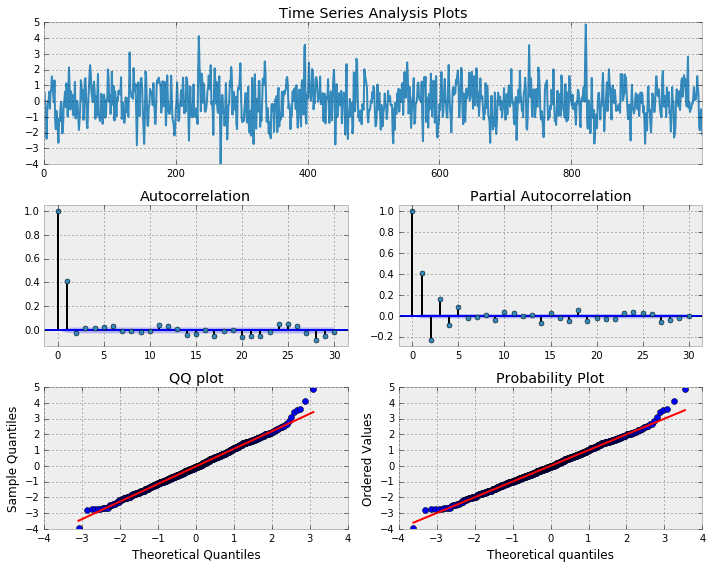

In [14]:
#simulate an MA(1) process

n=int(1000)


alphas=np.array([0.])
betas=np.array([0.6])

ar=np.r_[1,-alphas]
ma=np.r_[1,betas]

ma1=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n)
_=tsplot(ma1,lags=30)


In [15]:
#Fit the MA(1) model to our simulated time series
#Specify ARMA model with order (p,q)

max_lag=30
mdl=smt.ARMA(ma1,order=(0,1)).fit(maxlag=max_lag,method='mle',trend='nc')

print mdl.summary()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1390.513
Method:                           mle   S.D. of innovations              0.972
Date:                Thu, 18 May 2017   AIC                           2785.025
Time:                        08:20:17   BIC                           2794.841
Sample:                             0   HQIC                          2788.756
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ma.L1.y        0.5874      0.026     22.762      0.000         0.537     0.638
                                    Roots                                    
                 Real           Imaginary           M

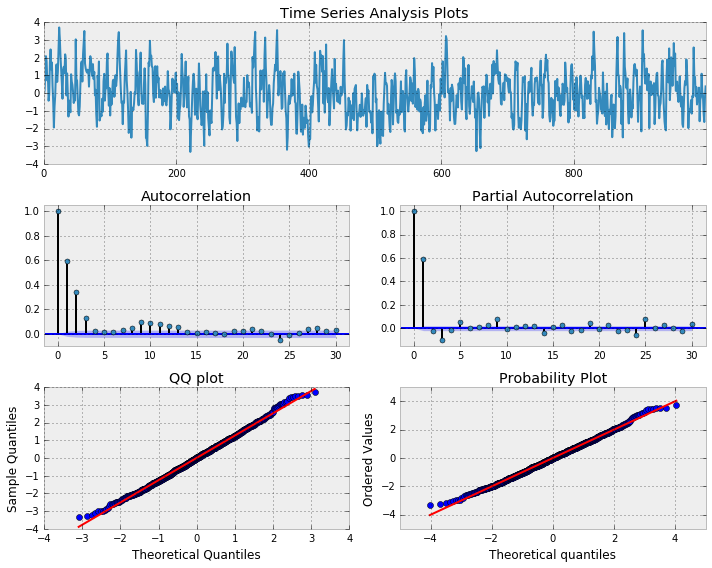

In [16]:
#Simulate MA(3) process with betas 0.6,0.4,0.2

n=int(1000)
alphas=np.array([0.])
betas=np.array([0.6,0.4,0.2])
ar=np.r_[1,-alphas]
ma=np.r_[1,betas]

ma3=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n)
_=tsplot(ma3,lags=30)

In [17]:
#Fit model to simulated time series

max_lag=30
mdl=smt.ARMA(ma3,order=(0,3)).fit(maxlag=max_lag,method='mle',trend='nc')
print mdl.summary()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1427.038
Method:                           mle   S.D. of innovations              1.008
Date:                Thu, 18 May 2017   AIC                           2862.075
Time:                        08:20:18   BIC                           2881.706
Sample:                             0   HQIC                          2869.536
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ma.L1.y        0.6025      0.031     19.322      0.000         0.541     0.664
ma.L2.y        0.4060      0.034     11.806      0.000         0.339     0.473
ma.L3.y        0.1683      0.031      5.420      0.0

## Autoregressive Moving average Models-ARMA(p,q)  
* AR(p) models try to capture(explain) the momentum and mean reversion effects often observed in trading markets.  
* MA(q) models try to capture(explain) the shock effects obeserved in the white noise terms.These shock effects could be thought of as unexpected events affecting the observation process e.g. Surprise earnings.A terrorist attck ,etc.  

The model formula is:
$$
\begin{align}
    x_t&=\alpha_1x_{t-1}+\alpha_2x_{t-2}+\cdots+w_t+\beta_1w_{t-1}+\beta_2w_{t-2}+\cdots+\beta_qw_{t-q}\\
       &=\sum_{i-1}^{p}\alpha_ix_{t-i}+w_t+\sum_{i=1}^{q}\beta_iw_{t-i} 
\end{align}
$$

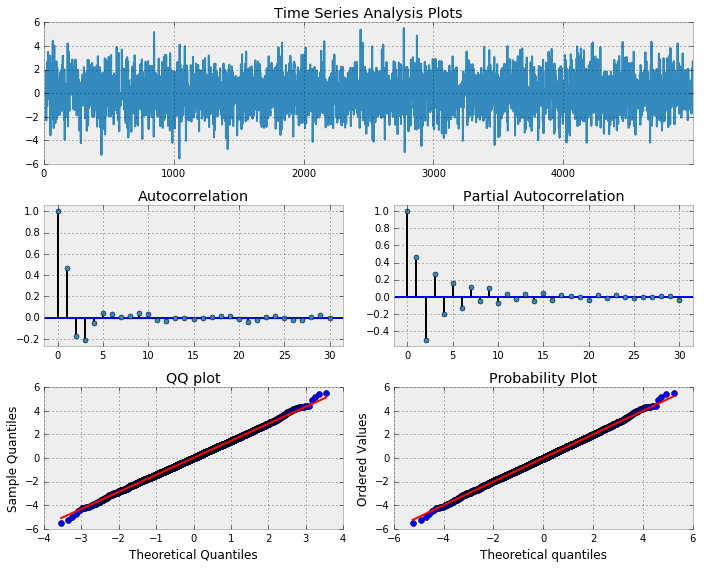

In [18]:
#Simulate an ARMA(2,2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]

max_lag=30
n=int(5000)#lots of samples to help estimates
burn=int(n/10.0) #number of samples to disdcard before fit

alphas=np.array([0.5,-0.25])
betas=np.array([0.5,-0.3])
ar=np.r_[1,-alphas]
ma=np.r_[1,betas]

arma22=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n,burnin=burn)
_=tsplot(arma22,lags=max_lag)

In [19]:
#fit the model

mdl=smt.ARMA(arma22,order=(2,2)).fit(maxlag=max_lag,method='mle',trend='nc',burnin=burn)
print mdl.summary()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7076.176
Method:                           mle   S.D. of innovations              0.996
Date:                Thu, 18 May 2017   AIC                          14162.352
Time:                        08:20:21   BIC                          14194.938
Sample:                             0   HQIC                         14173.773
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.y        0.4730      0.051      9.338      0.000         0.374     0.572
ar.L2.y       -0.2645      0.015    -17.489      0.000        -0.294    -0.235
ma.L1.y        0.5224      0.052     10.089      0.0

Next we simulate a ARMA(3,2) model.After,we cycle through a nontrivial number of combinations of p,q to fit an ARMA model to our simulated series.We choose the best combination based on which model produces the lowest Akaike information criterion(AIC)


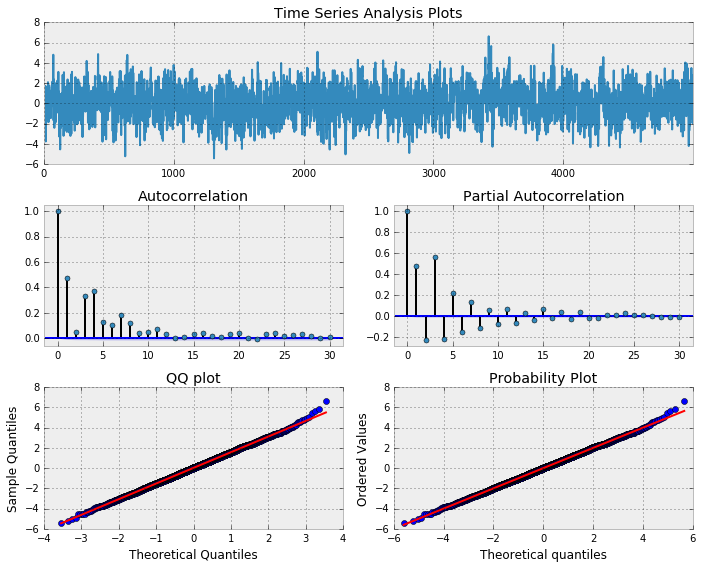

In [20]:
max_lag=30
n=int(5000)
burn=2000


alphas=np.array([0.5,-0.25,0.4])
betas=np.array([0.5,-0.3])

ar=np.r_[1,-alphas]
ma=np.r_[1,betas]

arma32=smt.arma_generate_sample(ar=ar,ma=ma,nsample=n,burnin=burn)
_=tsplot(arma32,lags=max_lag)

In [21]:
#pick best order by aic
#smallest aic value wins

best_aic=np.inf
best_order=None
best_mdl=None

rng=range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl=smt.ARMA(arma32,order=(i,j)).fit(method='mle',trend='nc')
            tmp_aic=tmp_mdl.aic
            print i,j,tmp_aic
            if tmp_aic<best_aic:
                best_aic=tmp_aic
                best_order=(i,j)
                best_mdl=tmp_mdl
        except:continue
print 'aci:{:6.5f} | order:{}'.format(best_aic,best_order)

0 1 15114.2855299
0 2 15083.7751138
1 0 17270.6171822
1 1 15094.4283137
1 4 14348.1354096
2 0 17007.2047345
2 1 15013.1222382
2 4 14350.089725
3 0 15105.7126031
3 1 14319.4741071
3 2 14212.0102586
3 3 14212.7309334
3 4 14214.6894972
4 0 14872.6587595
4 1 14221.5240997
4 2 14212.6790998
4 3 14214.0817861
4 4 14216.0514579
aci:14212.01026 | order:(3, 2)


In [22]:
mdl=smt.ARMA(arma32,order=(3,4)).fit(maxlag=max_lag,method='mle',trend='nc',burnin=burn)
print mdl.summary()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(3, 4)   Log Likelihood               -7099.345
Method:                           mle   S.D. of innovations              1.001
Date:                Thu, 18 May 2017   AIC                          14214.689
Time:                        08:20:48   BIC                          14266.827
Sample:                             0   HQIC                         14232.963
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.y        0.5417      0.031     17.272      0.000         0.480     0.603
ar.L2.y       -0.2979      0.035     -8.399      0.000        -0.367    -0.228
ar.L3.y        0.4371      0.031     14.094      0.0

In [23]:
mdl=smt.ARMA(arma32,order=(3,2)).fit(maxlag=max_lag,method='mle',trend='nc',burnin=burn)
print mdl.summary()

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(3, 2)   Log Likelihood               -7100.005
Method:                           mle   S.D. of innovations              1.001
Date:                Thu, 18 May 2017   AIC                          14212.010
Time:                        08:20:50   BIC                          14251.113
Sample:                             0   HQIC                         14225.715
                                                                              
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
ar.L1.y        0.5254      0.027     19.388      0.000         0.472     0.579
ar.L2.y       -0.2634      0.016    -16.458      0.000        -0.295    -0.232
ar.L3.y        0.4307      0.014     31.615      0.0

In [44]:
#get an sample data from database

from zht.data import data_handler
pdir(data_handler)

module attribute:
    __file__, __name__, __package__
other:
    __builtins__, datetime, np, os, pd
special attribute:
    __doc__
function:
    calculate_return_df: the invalid the data will be removed,such as those returns larger than 0.11 and etc.
    get_code_list: 
    get_df: :param code:like 000001.SZ
    get_index_df: 
    get_intersection_filenames: 
    get_return_df: 
    get_valid_codes: valid_codes means the length of trading day is larger than least_length
    preprocess_data: delete the first 20 ticker if a stock is newly listed

In [45]:
from imp import reload
reload(data_handler)

<module 'zht.data.data_handler' from 'c:\python27\zht\data\data_handler.py'>

In [65]:
lrets=data_handler.get_lrets('000001.SZ')
lrets.dropna(inplace=True)

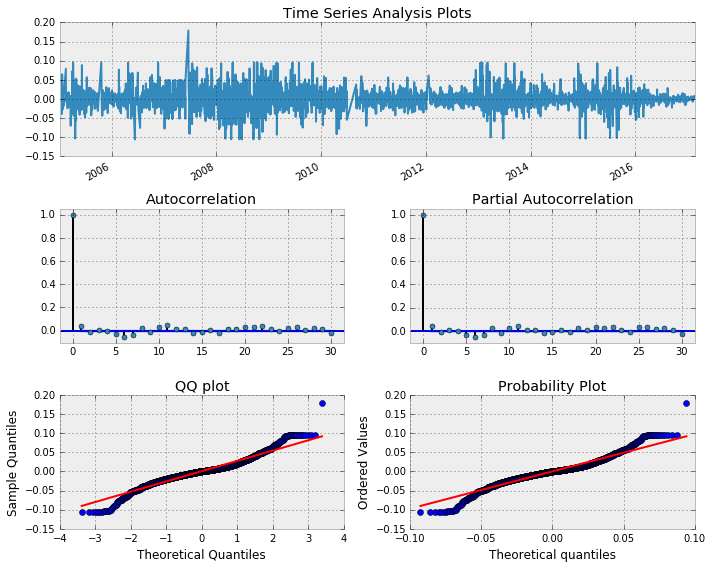

In [66]:
_=tsplot(lrets,lags=30)

##### Find the best order  

In [68]:
best_aic=np.inf
best_order=None
best_mdl=None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl=smt.ARMA(lrets,order=(i,j)).fit(method='mle',trend='nc')
            tmp_aic=tmp_mdl.aic
            print i,j,tmp_aic
            if tmp_aic<best_aic:
                best_aic=tmp_aic
                best_order=(i,j)
                best_mdl=tmp_mdl
        except:
            continue
print 'aic:{:6.5f} | order:{}'.format(best_aic,best_order)

0 1 -12267.6195339
0 2 -12265.9943219
0 3 -12264.0166823
0 4 -12262.0209764
1 0 -12267.4997527
1 1 -12265.9984559
2 0 -12265.9722648
2 1 -12264.0102496
2 2 -12272.4214606
3 0 -12264.0226439
3 1 -12262.0248037
3 2 -12266.2802985


c:\python27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 3 -12263.9443921
4 0 -12262.0548672
4 1 -12263.4980679
4 2 -12274.4047031


c:\python27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 4 -12276.0972025
aic:-12276.09720 | order:(4, 4)


In [57]:
print best_mdl.summary()

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 2791
Model:                     ARMA(4, 4)   Log Likelihood                6147.049
Method:                           mle   S.D. of innovations              0.027
Date:                Thu, 18 May 2017   AIC                         -12276.097
Time:                        09:50:53   BIC                         -12222.690
Sample:                    01-05-2005   HQIC                        -12256.816
                         - 02-16-2017                                         
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
ar.L1.close    -0.1727      0.049     -3.509      0.000        -0.269    -0.076
ar.L2.close     0.4489      0.029     15.392      0.000         0.392     0.506
ar.L3.close    -0.2083      0.046     -4.531    

The ACF and PACF are showing no significant autocorrelation.The QQ and Probability Plots show the residuals are approximately normal with heavt tails.However,this model's residuals do NOT look like white noise!Look as teh highlighted areas of obvious conditional heteroskedasticity (conditional volatility) that the model has not captured.

## Autoregressive Integrated Moving Average Models-ARIMA(p,d,q)  
ARIMA is a natural extension to the class of ARMA models.As previously mentioned many of our TS are not stationary,however thry can be made stationary by differencing.  
Without diving too deeply into the equation,just know the 'd' references the number of the times we are differencing the series.

In [70]:
#Fit ARIMA(p,d,q) model to lrets

best_aic=np.inf
best_order=None
best_mdl=None

for p in range(5):
    for d in range(2):
        for q in range(5):
            try:
                tmp_mdl=smt.ARIMA(lrets,order=(p,d,q)).fit(method='mle',trend='nc')
                tmp_aic=tmp_mdl.aic
                print p,d,q,tmp_aic
                if tmp_aic<best_aic:
                    best_aic=tmp_aic
                    best_order=(p,d,q)
                    best_mdl=tmp_mdl
            except:
                continue
print 'aic:{:6.5f} | order:{}'.format(best_aic,best_order)        

0 0 1 -12267.6195339
0 0 2 -12265.9943219
0 0 3 -12264.0166823
0 0 4 -12262.0209764
0 1 1 -12251.0200084
0 1 2 -12253.8408567
1 0 0 -12267.4997527
1 0 1 -12265.9984559
1 1 0 -11145.9653623
1 1 1 -12253.7207661
1 1 2 -12252.2277621
1 1 3 -12250.015166
1 1 4 -12248.779467
2 0 0 -12265.9722648
2 0 1 -12264.0102496
2 0 2 -12272.4214606
2 1 0 -11470.8485174
2 1 1 -12252.2057132
2 1 2 -12249.8450553


c:\python27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 3 -12250.0559606


c:\python27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 4 -12249.9484634
3 0 0 -12264.0226439
3 0 1 -12262.0248037
3 0 2 -12266.2802985


c:\python27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 0 3 -12263.9443921
3 1 0 -11639.7111545
3 1 1 -12250.2522216
3 1 2 -12248.6724187
3 1 3 -12249.9284947


c:\python27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 1 4 -12250.3962061
4 0 0 -12262.0548672
4 0 1 -12263.4980679
4 0 2 -12274.4047031


c:\python27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 0 4 -12276.0972025
4 1 0 -11722.1979248
4 1 1 -12248.2873932
4 1 2 -12246.9914892
4 1 3 -12247.9738899


c:\python27\lib\site-packages\statsmodels\tsa\tsatools.py:492: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
c:\python27\lib\site-packages\statsmodels\tsa\tsatools.py:493: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
c:\python27\lib\site-packages\statsmodels\tsa\tsatools.py:493: RuntimeWarning: invalid value encountered in divide
  (1+np.exp(-params))).copy()
c:\python27\lib\site-packages\statsmodels\tsa\tsatools.py:494: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
c:\python27\lib\site-packages\statsmodels\tsa\tsatools.py:495: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
c:\python27\lib\site-packages\statsmodels\tsa\tsatools.py:495: RuntimeWarning: invalid value encountered in divide
  (1+np.exp(-params))).copy()
c:\python27\lib\site-packages\statsmodels\tsa\tsatools.py:536: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-par

aic:-12276.09720 | order:(4, 0, 4)


It should be no surprise that the best model has a differencing of 0.Recall that we already took the first difference of log prices to calculate the stock returns.

#### Forcast

In [72]:
#create a 21 day forecast of the lrets series with 95%,99% CI
n_steps=21

f,err95,ci95=best_mdl.forecast(steps=n_steps) #95% CI
_,err99,ci99=best_mdl.forecast(steps=n_steps,alpha=0.01) #99% CI

idx=pd.date_range(lrets.index[-1],periods=n_steps,freq='D')
fc_95=pd.DataFrame(np.column_stack([f,ci95]),index=idx,
                   columns=['forecast','lower_ci_95','upper_ci_95'])
fc_99=pd.DataFrame(np.column_stack([ci99]),index=idx,
                  columns=['lower_ci_99','upper_ci_99'])
fc_all=fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2017-02-16,0.000369,-0.052047,-0.068517,0.052785,0.069255
2017-02-17,-0.000728,-0.053159,-0.069634,0.051703,0.068178
2017-02-18,-0.000855,-0.053286,-0.069761,0.051576,0.068051
2017-02-19,-0.001695,-0.054142,-0.070623,0.050753,0.067234
2017-02-20,-0.000283,-0.052732,-0.069212,0.052165,0.068645


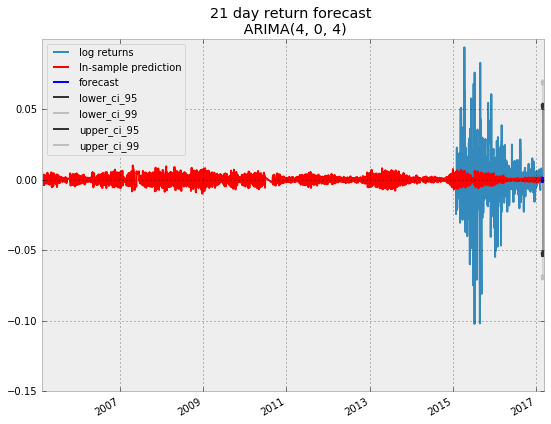

In [119]:
#Plot 21 day forecast for lrets 

plt.style.use('bmh')
fig=plt.figure(figsize=(9,7))
ax=plt.gca()

ts=lrets[-500:].copy()
ts.plot(ax=ax,label='log returns')
#insample prediction
pred = best_mdl.predict(21)
pred.plot(ax=ax,style='r-',label='In-sample prediction')

styles=['b-','0.2','0.75','0.2','0.75']
fc_all.plot(ax=ax,style=styles)
plt.fill_between(fc_all.index,fc_all.lower_ci_95,
                 fc_all.upper_ci_95,color='gray',alpha=0.7)

plt.fill_between(fc_all.index,fc_all.lower_ci_99,
                 fc_all.upper_ci_99,color='gray',alpha=0.2)
plt.title('{} day return forecast \n ARIMA{}'.format(n_steps,best_order))
plt.legend(loc='best',fontsize=10)

## Autoregressive Conditionally Heteroskedastic Models-ARCH(p)  
ARCH(p) models can be thought of as simply an AR(p) model applied to the variance of a time series.Another way to thick about ig,is that the variance of our time series NOW at time t,is conditional on past obaservations of the vaiance in previous periods.For example,the model below is an ARCH(1) model:  
$$Var(y_t|y_{t-1})=\sigma_t^2=\alpha_0+\alpha_1y_{t-1}^2$$


Assuming the series has zero mean we can express the model as:  
$$
\begin{equation}
y_t=\sigma_t\epsilon_t,with \; \sigma_t=\sqrt{\alpha_0+\alpha_1y_{t-1}^2},and \; \epsilon_t\sim iid(0,1)
\end{equation}
$$

<center>
$y_t=\sigma_t\epsilon_t$,with $\sigma_t=\sqrt{\alpha_0+\alpha_1y_{t-1}^2}$,and $ \epsilon_t\sim iid(0,1)$
</center>

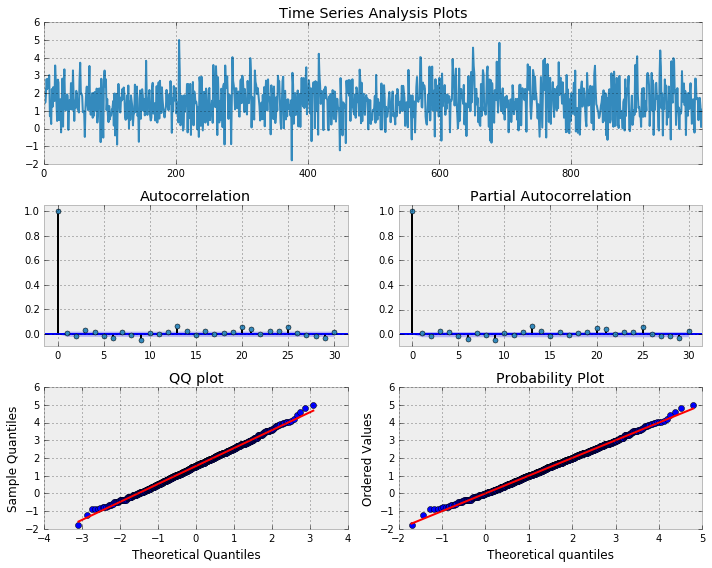

In [120]:
#Simulate ARCH(1) series

np.random.seed(13)

a0=2
a1=0.5

y=w=np.random.normal(size=1000)
Y=np.empty_like(y)

for t in range(len(y)):
    Y[t]=w[t]+np.sqrt(a0+a1*y[t-1]**2)
tsplot(Y,lags=30)

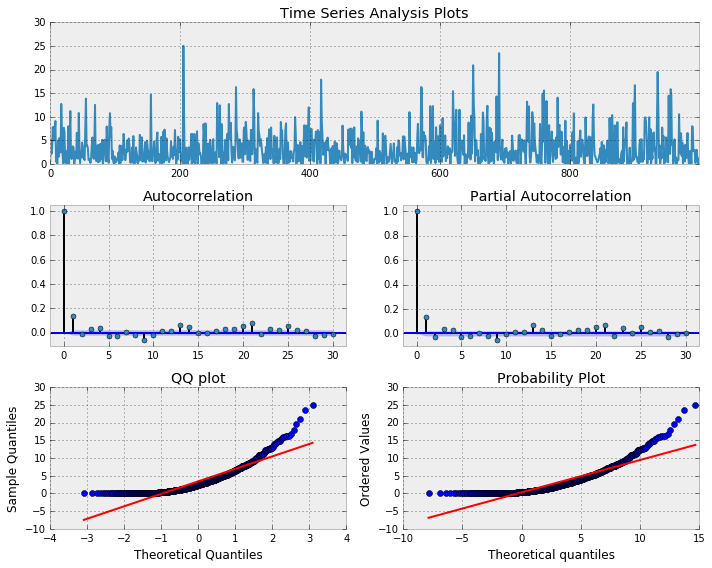

In [125]:
#simulated ARCH(1)**2 process
Ysquare=np.square(Y)
tsplot(Ysquare,lags=30)

Notice the ACF,and PACF seem to show significance at lag 1 indicating an AR(1) model for the variance may ge appropriate.

## Generalized Autoregressive Conditionally Heteroskedastic Models-GARCH(p,q)  
Simply put GARCH(p,q) is an ARMA model applied to the variance of a time series i.e.,it ahs an autoregressive term and a moveing average term.For example,the basic GARCH(1,1) formula is:
$$
\epsilon_t=\sigma_tw_t\\
\sigma_t^2=\alpha_1\epsilon_{t-1}^2+\beta_1\sigma_{t-1}^2
$$
Omega(w) is white noise.

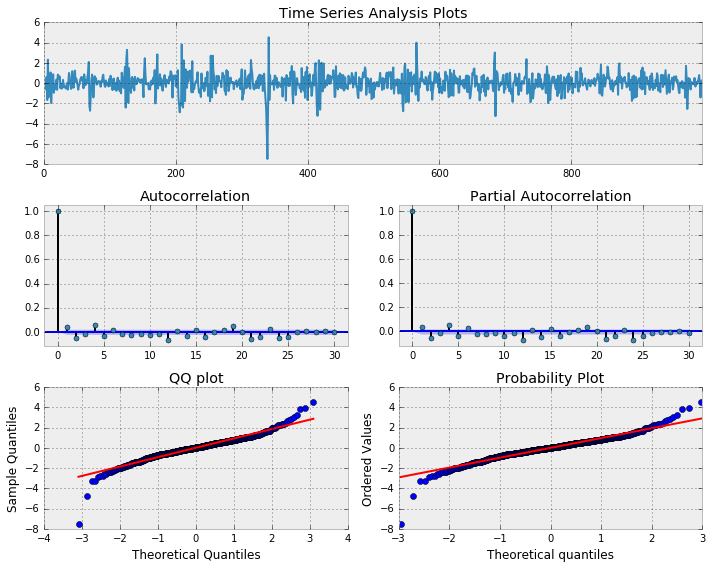

In [126]:
#simulate GARCH(1,1) process
np.random.seed(1)

a0=0.2
a1=0.5
b1=0.3

n=1000
w=np.random.normal(size=n)
eps=np.zeros_like(w)
sigsq=np.zeros_like(w)

for i in range(1,n):
    sigsq[i]=a0+a1*(eps[i-1]**2)+b1*sigsq[i-1]
    eps[i]=w[i]*np.sqrt(sigsq[i])
    
_=tsplot(eps,lags=30)

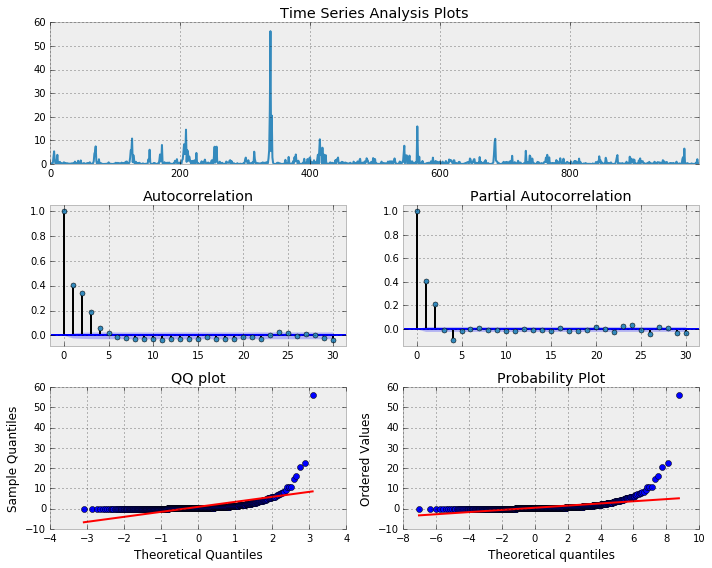

In [127]:
epsSquare=np.square(eps)
_=tsplot(epsSquare,lags=30)

There is clearly autocorrelation present and the significance of the lags in both the ACF and PACF indicate we need both AR and MA components for our model.

In [128]:
am=arch_model(eps)
res=am.fit(update_freq=5)
print res.summary()

Iteration:      5,   Func. Count:     38,   Neg. LLF: 1182.13566523
Iteration:     10,   Func. Count:     69,   Neg. LLF: 1178.08800677
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1178.08177485
            Iterations: 13
            Function evaluations: 87
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1178.08
Distribution:                  Normal   AIC:                           2364.16
Method:            Maximum Likelihood   BIC:                           2383.79
                                        No. Observations:                 1000
Date:                Thu, May 18 2017   Df Residuals:                      996
Time:                     

Now let's run through an example using lrets,The process is as follows:  
* iterate through combinations of ARIMA(p,d,q) models to best fit our time series
* Pick the GARCH model orders according to the ARIMA model with lowest AIC.
* Fit the GARCH(p,q) model to our time series
* Examine the model residuals and squared residuals for autocorrelation

In [129]:
def _get_best_model(TS):
    best_aic=np.inf
    best_order=None
    best_mdl=None
    
    for p in range(5):
        for d in range(2):
            for q in range(5):
                try:
                    tmp_mdl=smt.ARIMA(TS,order=(p,d,q)).fit(method='mle',trend='nc')
                    tmp_aic=tmp_mdl.aic
                    print p,d,q,tmp_aic
                    
                    if tmp_aic<best_aic:
                        best_aic=tmp_aic
                        best_order=(p,d,q)
                        best_mdl=tmp_mdl
                except:
                    continue
    
    print 'aic:{:6.5f} | order:{}'.format(best_aic,best_order)
    return best_aic,best_order,best_mdl

TS=lrets
res_tup=_get_best_model(TS)
    

0 0 1 -12267.6195339
0 0 2 -12265.9943219
0 0 3 -12264.0166823
0 0 4 -12262.0209764
0 1 1 -12251.0200084
0 1 2 -12253.8408567
1 0 0 -12267.4997527
1 0 1 -12265.9984559
1 1 0 -11145.9653623
1 1 1 -12253.7207661
1 1 2 -12252.2277621
1 1 3 -12250.015166
1 1 4 -12248.779467
2 0 0 -12265.9722648
2 0 1 -12264.0102496
2 0 2 -12272.4214606
2 1 0 -11470.8485174
2 1 1 -12252.2057132
2 1 2 -12249.8450553


c:\python27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 3 -12250.0559606


c:\python27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


2 1 4 -12249.9484634
3 0 0 -12264.0226439
3 0 1 -12262.0248037
3 0 2 -12266.2802985


c:\python27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 0 3 -12263.9443921
3 1 0 -11639.7111545
3 1 1 -12250.2522216
3 1 2 -12248.6724187
3 1 3 -12249.9284947


c:\python27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


3 1 4 -12250.3962061
4 0 0 -12262.0548672
4 0 1 -12263.4980679
4 0 2 -12274.4047031


c:\python27\lib\site-packages\statsmodels\base\model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


4 0 4 -12276.0972025
4 1 0 -11722.1979248
4 1 1 -12248.2873932
4 1 2 -12246.9914892
4 1 3 -12247.9738899
aic:-12276.09720 | order:(4, 0, 4)


In [131]:
resid=best_mdl.resid
resid_square=np.square(resid)

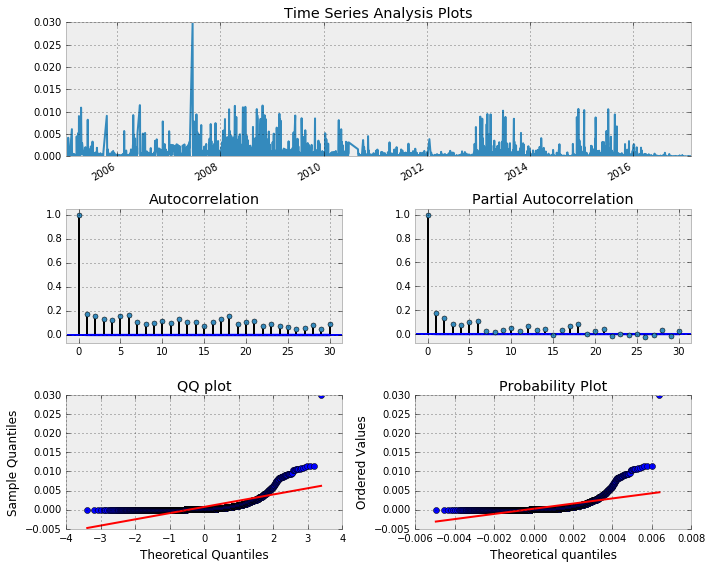

In [133]:
tsplot(resid_square,lags=30)

squared resisuals show autocorrelation.Let's fit a GARCH model and see how it does.